<a href="https://colab.research.google.com/github/AndrewDrury/FakeNewsML/blob/main/MSCI446_FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSCI Project - Fake News
Written by Andrew Drury & Michael Cheng

### Imports
All imports required for the project.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.sparse import hstack
from mlxtend.preprocessing import TransactionEncoder
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 1: Data Transformation

### Load data from tsv file
The tsv file contains 12,386 rows each containing a statement that has been fact checked with additional descriptive columns. A github repository was created in order to store the tsv file. The data is imported and assigned column names.

In [ ]:
# Link to the raw tsv file stored in a Github repository
datasetUrl = 'https://raw.githubusercontent.com/AndrewDrury/FakeNewsML/main/factCheck.tsv'

# Load tsv file, assign column names to tsv
df = pd.read_csv(datasetUrl, delimiter='\t', engine='python', header=None, names=['id', 'label', 'statement', 'subjects', 'speaker', 'job-title', 'state', 'party-affiliation', 'barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'context'])

### Apply Text Mining Methods to Prep Inputs

To predict the truthfulness of a statement, the words in the statement and context need to be extracted and transformed into a more useful form of input.

The following steps are taken to transform the statements and contexts into tokens. The subjects do not need to be lemmatized as they are already cleaned with only 144 possible values.

1.   All characters in the statements and contexts will be transformed to lowercase
2.   The strings will be split into tokens, each token representing a continuous sequence of letters
3.   All characters not present in the alphabet will be removed
4.   Remove common stopwords that do not provide any useful information (words like 'the', 'a')
5.   The WordNetLemmatizer package will be used to transform tokens into lemmas. WordNetLemmatizer is chosen over other word processing tools such as a Stemmer since WordNetLemmatizer transforms words into their contextual root form. A stemmer often times neglects context when removing characters from a word leading to alternate meanings. After applying lemmatization, similar tokens will be reduced to their singular and common root. For example, the words 'likes', 'liked', 'liking', and 'likely' will all be reduced to their lemma 'like'.

In [ ]:
def getTokens(column, removeUnique=False):
  # Transform all characters to lowercase
  lowerCase = column.str.lower()

  # Tokenize strings
  tokens = lowerCase.apply(word_tokenize)

  # Remove all characters not present in the alphabet
  tokens = tokens.apply(lambda words: [re.sub(r'[^a-z]+', '', token) for token in words])

  # Remove common stopwords that do not provide any useful information (words like 'the', 'a')
  stopList = stopwords.words('english')
  tokens = tokens.apply(lambda statement: [token for token in statement if token not in (stopList)])

  # Lemmatize tokens in strings using WordNetLemmatizer
  wnLemmatizer = nltk.WordNetLemmatizer()
  tokens = tokens.apply(lambda x: [wnLemmatizer.lemmatize(y) for y in x])
  tokens = pd.DataFrame(val for val in tokens)
  return tokens

# Create token matrix for all statements
statementMatrix = getTokens(df['statement'])

# The contexts contained non-string NaN values, all NaN values are replaced by an empty string
contextsNoNan = df['context'].replace(np.nan,'')

# Create token matrix for all contexts
contextMatrix = getTokens(contextsNoNan)

# Store subjects, subjects do not need to be lemmatized as they are already processed
subjects = df['subjects'].str.split(',', expand=True)

# Store the truth result labels
truthLabels = df['label']

### Create TF-IDF Matrix for Supervised Classification

To predict the truthfulness of a statement given a context and some subjects, a TF-IDF (term frequency inverse document frequency matrix) of tokens will be created from the statements, contexts, and subjects.

A TF-IDF 2D matrix will be created from the inputs prepared above using SKLearn's TfidfVectorizer. Each row in the matrix created will represent a statement with a given context and subjects. The TF-IDF score is computed by multiplying the term frequency TF in the statement by the inverse document frequency IDF. The inverse document frequency is calculated by dividing the total number of statements by the number of documents that contain the given token. The TF-IDF score is commonly used with textual data as it augments unique and relevant terms in a body of text such as a statement.

In [ ]:
def tfidfMatrix(input):
  # Tokens need to reform into sentences split with a space ' ' to use the TF-IDF vectorizer
  inputList = input.tolist()
  # Remove all empty strings
  inputList = [[val for val in row if val != ''] for row in inputList]
  # Create a list of strings, each string representing an entire row (needed for tfidf)
  inputList = [' '.join(val) for val in inputList]

  # Create TF-IDF Matrix of tokens
  tfidfVectorizer = TfidfVectorizer()
  tfidfFinal = tfidfVectorizer.fit_transform(inputList)

  return tfidfFinal, tfidfVectorizer

# Group together statement tokens, subjects, and context tokens as the input for supervised learning
xSupervised = pd.concat([statementMatrix, subjects, contextMatrix], axis=1)

# Replace all 'None' values with empty string ''
xSupervised = np.asarray(xSupervised.fillna(value=''))

# Create tfidf matrix
xSupervised, xVectorizer = tfidfMatrix(xSupervised)

# Store truth labels
ySupervised = truthLabels

# Set all truth labels that are 'true' and 'mostly-true' to true, set all other labels to 'false'
ySupervised = ySupervised.replace(['mostly-true'],'true')
ySupervised = ySupervised.replace(['half-true','barely-true','pants-fire'],'false')

print('There are %s rows and %s columns in the supervised tfidf matrix.'% (xSupervised.shape[0], len(xVectorizer.get_feature_names_out())))

There are 12836 rows and 12662 columns in the supervised tfidf matrix.


### Encode Input Data for Unsupervised Learning with the Apriori Algorithm

To apply the apriori algorithm, the dataset of tokens and subjects needs to be encoded with values of 0 or 1. Additionally, the tokens 'true' and 'false' need to be modified for the statement and context tokens to avoid collisions with the fact check label. All other fact check labels contain a hyphen, which has been stripped of all tokens. Thus, no collision will occur and only 'true' and 'false' need to be modified. The label 'true' will become 'true_' and 'false' will become 'false_'.

In [ ]:
# Group together statement tokens, subjects, context tokens for unsupervised learning input
aprioriInput = pd.concat([statementMatrix, subjects, contextMatrix, truthLabels], axis=1)

# Replace all instances of 'true' and 'false' with 'true_' and 'false_' to distinguish
# naturally occuring strings from the fact check labels, then add fact check labels to dataset
# Note: all other fact check labels (ex: mostly-true) contain a hyphen which has
# been removed from the rest of the dataset, thus no collision will occur
aprioriInput = aprioriInput.replace(['true'],'true_')
aprioriInput = aprioriInput.replace(['false'],'false_')

# Add truth labels to the dataset now that exisiting 'true' and 'false' have been modified
aprioriInput = pd.concat([aprioriInput, truthLabels], axis=1)

# Replace all none values with an empty string
aprioriInput = aprioriInput.fillna(value='')
aprioriInput = aprioriInput.values.tolist()

# Transform data into encoded matrix for the apriori algorithm
encoder = TransactionEncoder()
aprioriInput = encoder.fit(aprioriInput).transform(aprioriInput)

# Convert input data into dataframe
aprioriInput = pd.DataFrame(aprioriInput, columns=encoder.columns_)

# Drop the column containing empty strings
aprioriInput.drop('', axis=1, inplace=True)

print('There are %s rows and %s columns in the unsupervised encoded matrix.'% (aprioriInput.shape[0], aprioriInput.shape[1]))

There are 12836 rows and 12724 columns in the unsupervised encoded matrix.


## Part 2: Data Description

Mean:  2139.3333333333335
Median:  2287.0
--------------------
 true           2063
mostly-true    2466
half-true      2638
barely-true    2108
false          2511
pants-fire     1050
Name: label, dtype: int64


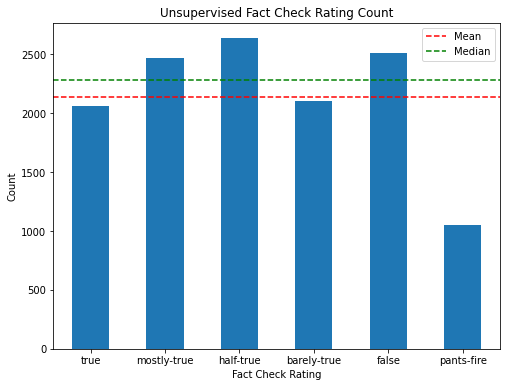

In [ ]:
# Create bar chart for fact check label counts used for unsupervised learning
labelCounts = truthLabels.value_counts()
labelCounts = labelCounts.reindex(['true','mostly-true','half-true','barely-true','false','pants-fire'])
labelCountPlot = labelCounts.plot(kind='bar', rot=0, title='Unsupervised Fact Check Rating Count', label='_nolegend_', figsize=(8,6))

labelCountPlot.set_xlabel('Fact Check Rating')
labelCountPlot.set_ylabel('Count')

mean = labelCounts.mean()
median = labelCounts.median()
labelCountPlot.axhline(mean, color='r', ls='--', label="Mean")
labelCountPlot.axhline(median, color='g', ls='--', label="Median")
labelCountPlot.legend()
print('Mean: ', mean)
print('Median: ', median)
print('-'*20+'\n', labelCounts)


Mean:  6418.0
Median:  6418.0
--------------------
 false    8307
true     4529
Name: label, dtype: int64


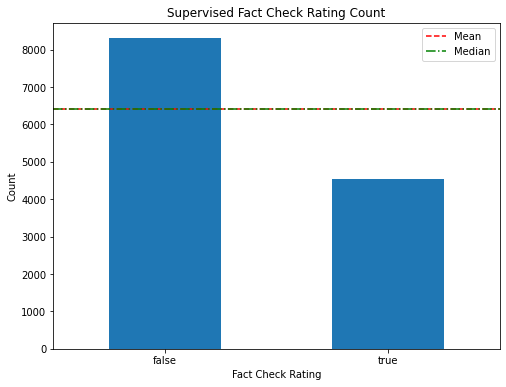

In [ ]:
# Create bar chart for fact check label counts used for supervised learning
labelCounts = ySupervised.value_counts()
labelCountPlot = labelCounts.plot(kind='bar', rot=0, title='Supervised Fact Check Rating Count', label='_nolegend_', figsize=(8,6))

labelCountPlot.set_xlabel('Fact Check Rating')
labelCountPlot.set_ylabel('Count')

mean = labelCounts.mean()
median = labelCounts.median()
labelCountPlot.axhline(mean, color='r', ls='--', label="Mean")
labelCountPlot.axhline(median, color='g', ls='-.', label="Median")
labelCountPlot.legend()
print('Mean: ', mean)
print('Median: ', median)
print('-'*20+'\n', labelCounts)

(5103,)


Text(0, 0.5, 'Count')

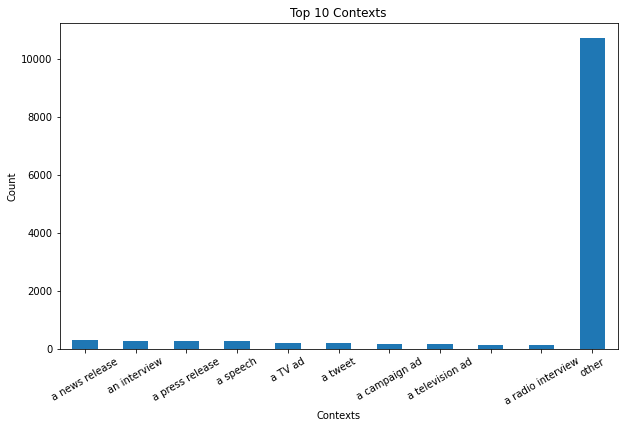

In [ ]:
# Generate plot showing the count of the top 10 contexts
counts = contextsNoNan.value_counts()
print(counts.shape)
otherCounts = counts[10:].sum()
countsMatrix = counts[:10]
countsMatrix = countsMatrix.append(pd.Series([otherCounts], index=['other']))

countsPlot = countsMatrix.plot(kind='bar', rot=30, title='Top 10 Contexts', label='_nolegend_',figsize=(10,6))
countsPlot.set_xlabel('Contexts')
countsPlot.set_ylabel('Count')

Text(0, 0.5, 'Count')

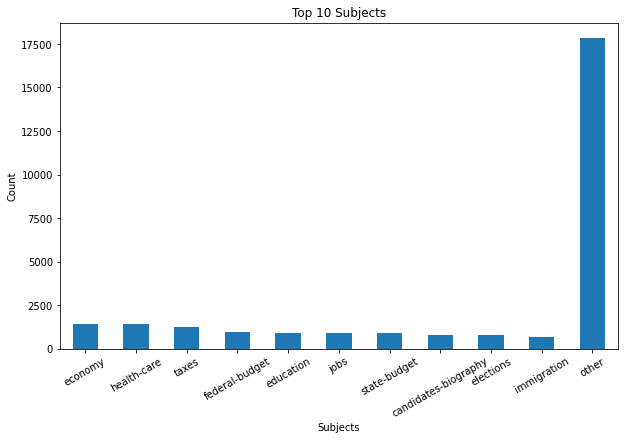

In [ ]:
# Generate plot showing the count of the top 10 subjects
splitSubjects = []
for row in df['subjects']:
    for sub in row.split(','):
        splitSubjects.append(sub)
subDf = pd.DataFrame(splitSubjects)
counts = subDf.value_counts()
countsMatrix = counts[:10]

# Clean indexes (each subject is stored in tuple, change to tuple to subjet itself)
indexes = countsMatrix.index.tolist()
newIndexes = [index[0] for index in indexes]
countsMatrix.index = newIndexes
otherCounts = counts[10:].sum()
countsMatrix = countsMatrix.append(pd.Series([otherCounts], index=['other']))

countsPlot = countsMatrix.plot(kind='bar', rot=30, title='Top 10 Subjects', label='_nolegend_',figsize=(10,6))
countsPlot.set_xlabel('Subjects')
countsPlot.set_ylabel('Count')

## Part 3: Supervised Learning - Classification

The TF-IDF matrix is split into 5 folds and done as an 80-20 train/test. metrics lists are created for the 4 metrics accuracy, precision, recall, and f1. The naive bayes and logistic regression classifiers are run separately using the TF-IDF matrix.  

Initially both algorithms were run with the 6 y variable classes. To try and improve performance we grouped the y variables class labels into 2 groups instead of the 6 ('true','mostly-true','half-true','barely-true','false','pants-fire'). So 'true' and 'mostly-true' become 'true' and everything else becomes 'false'.

In [ ]:
folds = 5

metrics_supervised_a = []
metrics_supervised_p = []
metrics_supervised_r = []
metrics_supervised_f = []

# SPLIT DATASET 80-20 TRAIN/TEST with Stratified kfold validation using 5 folds
# Stratified kfold preserves the same proportions of each class in the split
kIndices = StratifiedKFold(n_splits=folds)
for trainIndice, testIndice in kIndices.split(xSupervised, ySupervised):
  train_x, test_x = xSupervised[trainIndice], xSupervised[testIndice]
  train_y, test_y = ySupervised[trainIndice], ySupervised[testIndice]

  # Train classification model with train_x and train_y
  #naive bayes
  naive_bayes_classifier = MultinomialNB()
  naive_bayes_classifier.fit(train_x, train_y)
  #logistic regression
  #logistic_regression_classifier = LogisticRegression()
  #logistic_regression_classifier.fit(train_x, train_y)


  # Test model with test_x and test_y
  #naive bayes
  y_pred = naive_bayes_classifier.predict(test_x)

  #logistic regression
  #y_pred = logistic_regression_classifier.predict(test_x)

  # Compute metrics for model for current kfold
  accuracy = metrics.accuracy_score(test_y, y_pred)
  precision = metrics.precision_score(test_y, y_pred,average='weighted',zero_division=1)
  recall = metrics.recall_score(test_y, y_pred,average='weighted',zero_division=1)
  f1 = metrics.f1_score(test_y, y_pred,average='weighted',zero_division=1)

  metrics_supervised_a.append(accuracy)
  metrics_supervised_p.append(precision)
  metrics_supervised_r.append(recall)
  metrics_supervised_f.append(f1)

# Calculate metric averages across the 5 kfolds

print(sum(metrics_supervised_a)/folds)
print(sum(metrics_supervised_p)/folds)
print(sum(metrics_supervised_r)/folds)
print(sum(metrics_supervised_f)/folds)


0.650124695542635
0.6207905928702726
0.650124695542635
0.5331349656156716


## Part 4: Unsupervised Learning - Association Rule Mining

The encoded matrix input assembled in Part 2 will be fed into the Apriori algorithm to generate a list of frequent itemsets. Then, the itemsets will be pruned, removing all sets that do not contain a truth label. Itemsets with truth labels are exclusively relevant as we are seeking to identify trends associated with truthfulness. The pruned sets will be passed into the association rules method in order to generate rules.

In [ ]:
# Generate frequent itemsets with minimum support
def getFrequentItemset(input, supportThreshold):
  frequentItemsets = apriori(input,min_support=supportThreshold,use_colnames=True)
  return frequentItemsets

# Generate association rules for frequent itemsets
def getRules(itemsets,confidenceThreshold):
  rules = association_rules(itemsets,metric='confidence',min_threshold=confidenceThreshold)
  
  # Keep only rules that contain truth labels
  truthLabels = {'true','mostly-true','half-true','barely-true','false','pants-fire'}
  removeIndexes = []
  for index, values in rules.iterrows():
    if not any(label in values['antecedents'] or label in values['consequents'] for label in truthLabels):
      removeIndexes.append(index)
  
  # Drop all rules that do not have truth labels
  rules.drop(rules.index[removeIndexes], inplace=True)
  return rules

# Setup thershold parameters for experiements
highSupport = 0.02
lowSupport = 0.01
highConfidence = 0.99
lowConfidence = 0.1

# Define experiments to run
experiments = [
  {
      'title':'Low Support and Low Confidence',
      'support':lowSupport,
      'confidence':lowConfidence,
  },
  {
      'title':'Low Support and High Confidence',
      'support':lowSupport,
      'confidence':highConfidence,
  },
  {
      'title':'High Support and Low Confidence',
      'support':highSupport,
      'confidence':lowConfidence,
  },
  {
      'title':'High Support and High Confidence',
      'support':highSupport,
      'confidence':highConfidence,
  },
]

rulesets = []

# Run experiments for each support and confidence threshold
for index, experiment in enumerate(experiments):
  frequentItemsets = getFrequentItemset(aprioriInput,experiment['support'])
  rules = getRules(frequentItemsets,experiment['confidence'])

  # Sort rules by confidence, then by support for all ties
  rules.sort_values(['confidence','support'],ascending = [False, False], inplace=True)
  
  # Reindex rules
  rules.index = range(len(rules))

  rulesets.append(rules)

  # Print results of experiment, including top 10 and bottom 10 association rules
  print('EXPERIMENT #%s'% (index+1))
  print('Title: %s'% experiment['title'])
  print('Support Threshold: %s'% experiment['support'])
  print('Confidence Threshold: %s'% experiment['confidence'])
  print('# Rules: %s'% len(rules))
  print('-'*60, '\nTop 10 Rules:')
  print(rules[['antecedents','consequents','support','confidence']][:10])
  print('-'*60, '\nBottom 10 Rules:')
  print(rules[['antecedents','consequents','support','confidence']][-10:])
  print('\n' + '='*80)

EXPERIMENT #1
Title: Low Support and Low Confidence
Support Threshold: 0.01
Confidence Threshold: 0.1
# Rules: 448
------------------------------------------------------------ 
Top 10 Rules:
             antecedents consequents   support  confidence
0                (false)    (false_)  0.195622         1.0
1                 (true)     (true_)  0.160720         1.0
2           (say, false)    (false_)  0.047990         1.0
3     (false, interview)    (false_)  0.037940         1.0
4            (say, true)     (true_)  0.031240         1.0
5          (state, true)     (true_)  0.026488         1.0
6   (false, health-care)    (false_)  0.025865         1.0
7  (false_, health-care)     (false)  0.025865         1.0
8      (interview, true)     (true_)  0.025631         1.0
9         (state, false)    (false_)  0.025164         1.0
------------------------------------------------------------ 
Bottom 10 Rules:
         antecedents              consequents   support  confidence
438    (healt

## Visualizing Trends with WordCloud Plots

In [ ]:
# Generate new rules for WordCloud plot given a very low support threshold and at least 0.5 confidence value
# THIS WILL TAKE A LONG TIME TO RUN given the low support threshold
supportThreshold = 0.002
confidenceThreshold = 0.5

frequentItemsets = getFrequentItemset(aprioriInput,supportThreshold)
rules = getRules(frequentItemsets,confidenceThreshold)

true WordCloud Plot


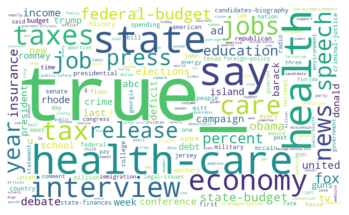

mostly-true WordCloud Plot


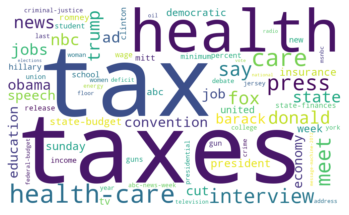

half-true WordCloud Plot


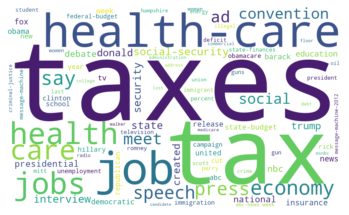

barely-true WordCloud Plot


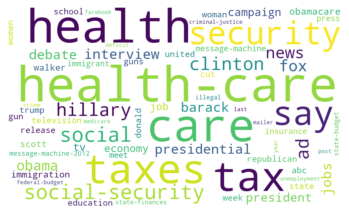

false WordCloud Plot


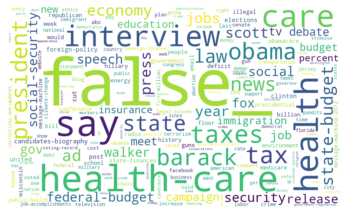

pants-fire WordCloud Plot


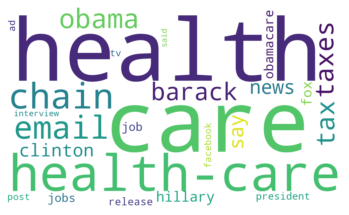

In [ ]:
# Create dictrionary of words and their calculated sizes for WordCloud plot for the given label
def getWordSizeDict(label, rules):
  wordSizeDict = {}

  # Create dictrionary of words and their calculated sizes for WordCloud plot for the given label
  for index, values in rules.iterrows():
    # print(values)
    if label in values['antecedents'] or label in values['consequents']:
      words = list(values['antecedents']) + list(values['consequents'])
      words.remove(label)
      
      # Calculate size for given word
      # The size will be a summation of the support x confidence for all occurences of the word in rules
      sizeMeasure = values['support'] * values['confidence']

      for word in words:
        if word in wordSizeDict:
          wordSizeDict[word] += sizeMeasure
        else:
          wordSizeDict[word] = sizeMeasure
  return wordSizeDict

# Create word cloud for given word size dictionary
def createWordCloud(wordSizeDict):
  wordCloud = WordCloud(width = 1000, height = 600, background_color='white').generate_from_frequencies(wordSizeDict)
  return wordCloud

truthLabelsList = ['true','mostly-true','half-true','barely-true','false','pants-fire']

# Create a WordCloud plot for each degree of truthfulness based on rules with very low support threshold and at least 0.5 confidence
for index in range(len(truthLabelsList)):
  label = truthLabelsList[index]

  # Generate word size dictionary for current fact-check label
  wordSizesDict = getWordSizeDict(label, rules)

  # Create wordCloud
  wordCloud = createWordCloud(wordSizesDict)

  print(label + ' WordCloud Plot')
  plt.figure(index)
  plt.imshow(wordCloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
